# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

# Scenario 1: State tax board

You are a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year.

Goal is to create:
- a report of current liquor sales by county
- projections (of sales) for the rest of the year

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from sklearn import metrics, datasets, linear_model, feature_selection, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cross_validation import cross_val_predict, cross_val_score, train_test_split

from __future__ import division, print_function, unicode_literals
pd.set_option("display.max_columns", 300)

# Load the data

In [165]:
## Load the data into a DataFrame
iowa_df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")
iowa_df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [166]:
# check if columns have correct data types
iowa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: float64(4), int64(

In [167]:
## transform dates, find out date range
iowa_df["Date"] = pd.to_datetime(iowa_df["Date"], format="%m/%d/%Y")
print("Min date:", min(iowa_df["Date"]))
print("Max date:", max(iowa_df["Date"]))

Min date: 2015-01-05 00:00:00
Max date: 2016-03-31 00:00:00


In [168]:
## transform money columns: do not use floats, because of rounding errors
## new values in cents, rename columns
for col in ("State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"):
    iowa_df[col] = (iowa_df[col].str.replace(r'[,$]', '').astype(float)*100).astype(int)

iowa_df.rename(columns={"State Bottle Cost" : "State Bottle Cost (Cents)",
                        "State Bottle Retail" : "State Bottle Retail (Cents)",
                        "Sale (Dollars)" : "Sale (Cents)"}, inplace=True)

In [169]:
# drop column with gallons (will use only liters)
iowa_df.drop("Volume Sold (Gallons)", axis=1, inplace=True)

In [170]:
# some "numeric" columns should actually be categories
iowa_df["Store Number"] = iowa_df["Store Number"].astype("category")
iowa_df["County Number"] = iowa_df["County Number"].astype("category")
iowa_df["Category"] = iowa_df["Category"].astype("category")
iowa_df["Vendor Number"] = iowa_df["Vendor Number"].astype("category")
iowa_df["Item Number"] = iowa_df["Item Number"].astype("category")

In [171]:
iowa_df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost (Cents),State Bottle Retail (Cents),Bottles Sold,Sale (Cents),Volume Sold (Liters)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,450,675,12,8100,9.0
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,1375,2063,2,4126,1.5
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,1259,1889,24,45336,24.0
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,950,1425,6,8550,10.5
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,720,1080,12,12960,21.0


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [172]:
# this will show the min, max, mean, std and percentiles for the numeric columns
iowa_df.describe()

,Bottle Volume (ml),State Bottle Cost (Cents),State Bottle Retail (Cents),Bottles Sold,Sale (Cents),Volume Sold (Liters)
count,270955.000000,270955.000000,270955.000000,270955.000000,2.709550e+05,270955.000000
mean,924.830341,977.274817,1467.508675,9.871285,1.289019e+04,8.981351
std,493.088489,704.702580,1057.018623,24.040912,3.830274e+04,28.913690
min,50.000000,89.000000,134.000000,1.000000,1.340000e+02,0.100000
25%,750.000000,550.000000,827.000000,2.000000,3.045000e+03,1.500000
50%,750.000000,800.000000,1227.000000,6.000000,7.056000e+03,5.250000
75%,1000.000000,1192.000000,1788.000000,12.000000,1.350000e+04,10.500000
max,6000.000000,42500.000000,63750.000000,2508.000000,3.639240e+06,2508.000000


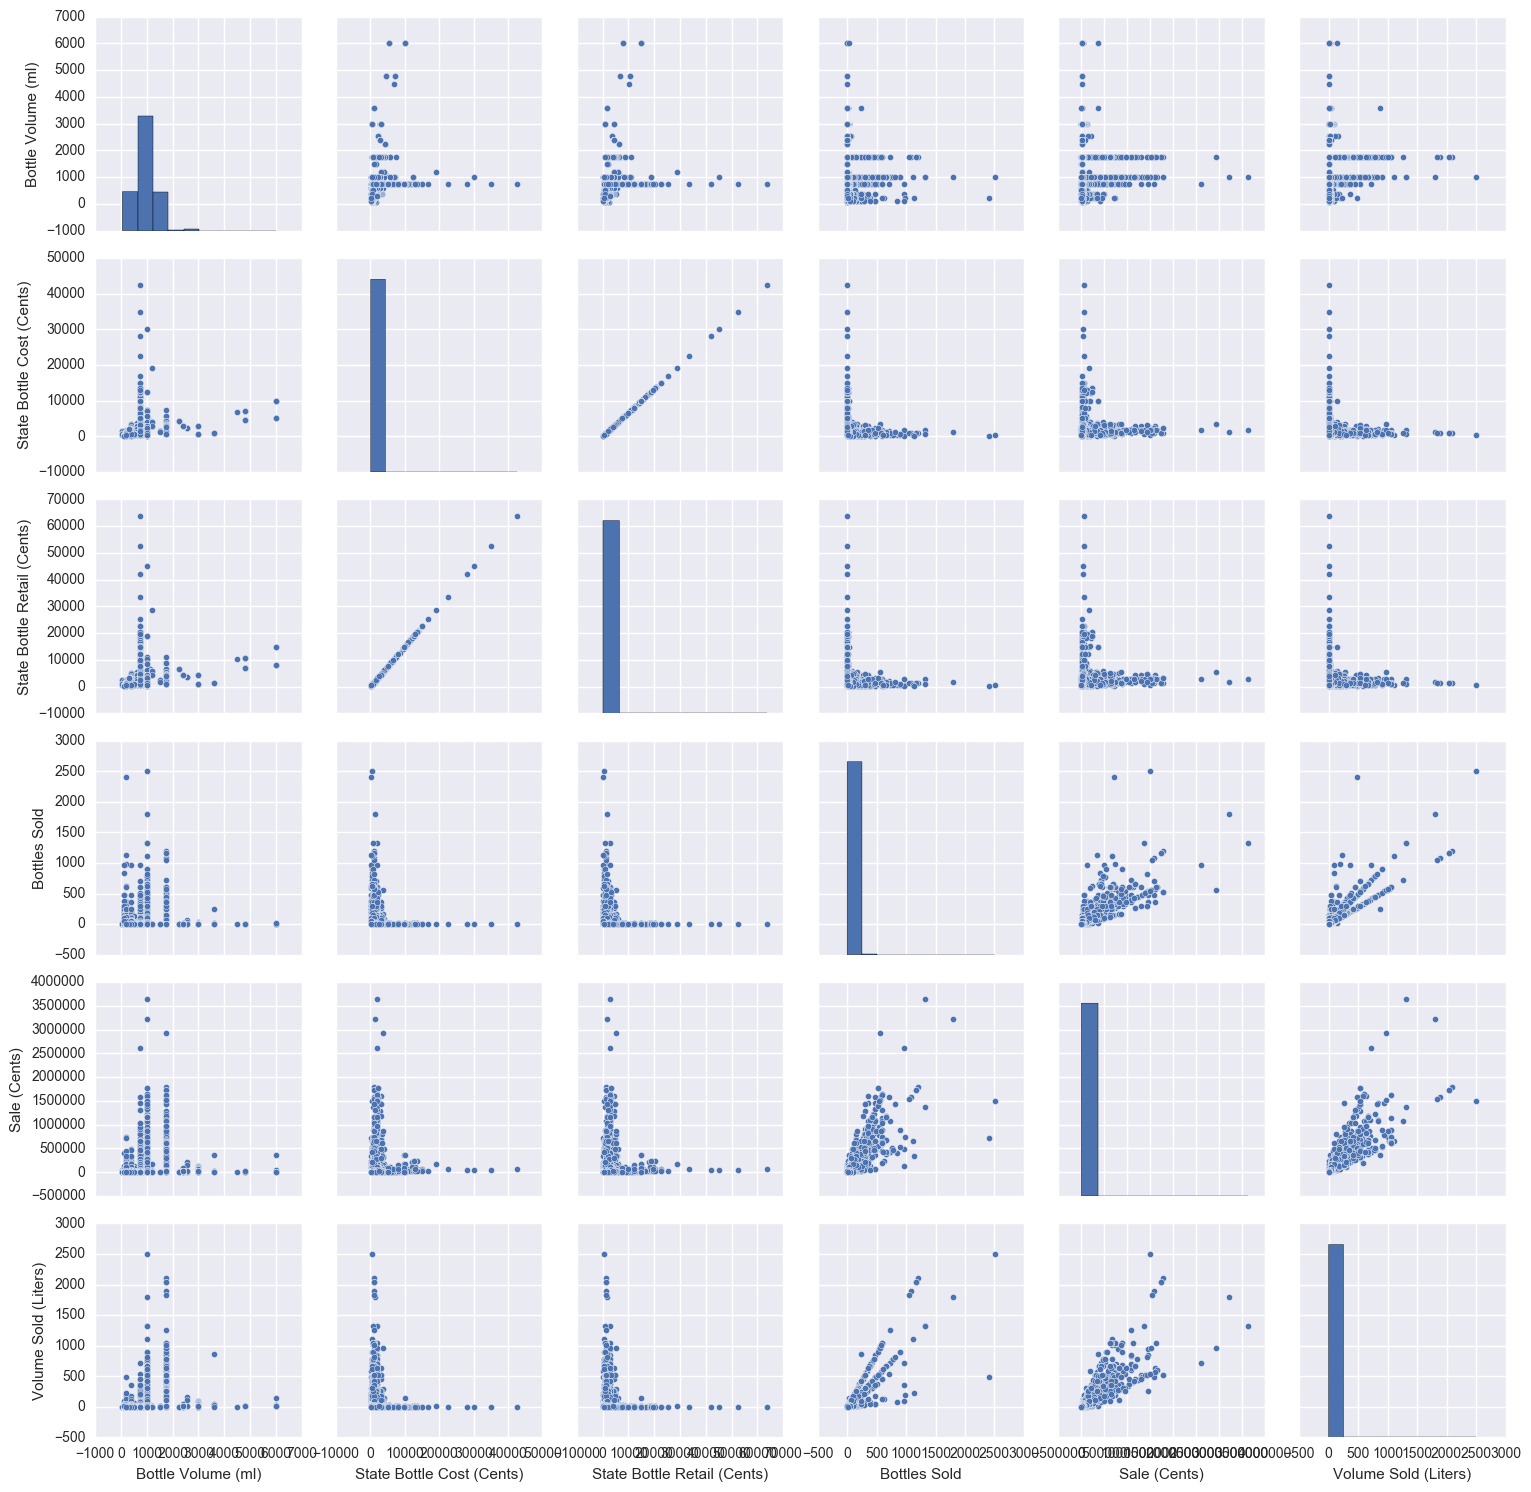

In [173]:
# this will show correlations between numeric variables
# and histograms for each of them
# sns.pairplot(iowa_df, vars=["Bottle Volume (ml)", "State Bottle Cost (Cents)", 
#                            "State Bottle Retail (Cents)", "Bottles Sold",
#                            "Sale (Cents)", "Volume Sold (Liters)"])

In [174]:
# "State Bottle Cost (Cents)" and "State Bottle Retail (Cents)" are perfectly correlated
# one of them should be droped
iowa_df.drop("State Bottle Cost (Cents)", axis=1, inplace=True)

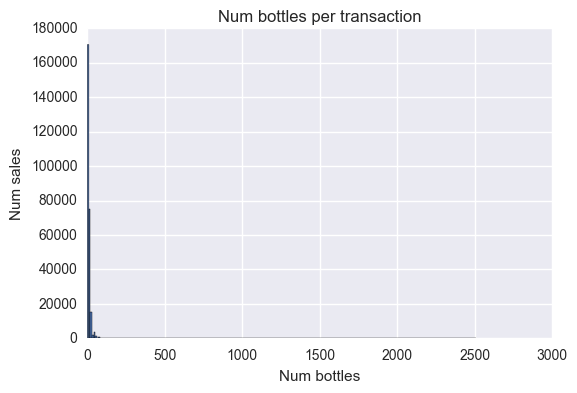

In [209]:
# histogram for the number of bottles per transaction
nbins = max(iowa_df["Bottles Sold"])//10
iowa_df["Bottles Sold"].hist(bins=nbins)
plt.title("Num bottles per transaction")
plt.xlabel("Num bottles")
plt.ylabel("Num sales")
plt.show()

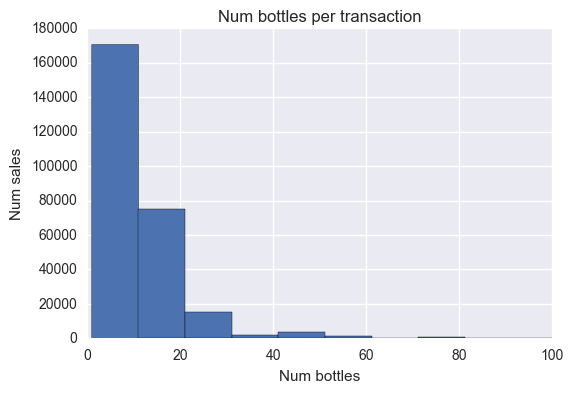

In [215]:
# this is a highly positively skewed distribution
# zoom in in the most frequent numbers of bottles sold by transaction
iowa_df["Bottles Sold"].hist(bins=nbins)
plt.axis([0, 100, 0, 180000])
plt.title("Num bottles per transaction")
plt.xlabel("Num bottles")
plt.ylabel("Num sales")
plt.show()

# the vast majority is up to 20 bottles

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

This is explained in comments throughout the previous code.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [175]:
# create columns with year and month
iowa_df["Year"] = map(lambda x: x.year, iowa_df["Date"])
iowa_df["Month"] = map(lambda x: x.month, iowa_df["Date"])
iowa_df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Retail (Cents),Bottles Sold,Sale (Cents),Volume Sold (Liters),Year,Month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,675,12,8100,9.0,2015,11
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,2063,2,4126,1.5,2016,3
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,1889,24,45336,24.0,2016,2
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,1425,6,8550,10.5,2016,2
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,1080,12,12960,21.0,2015,8


In [191]:
# Calculate the yearly liquor sales for each store using the provided data. 
# You can add up the transactions for each year, and store sales in 2015 
# specifically will be used later as your target variable.

sales_2015 = iowa_df[iowa_df["Year"] == 2015]

sales_store_2015 = pd.pivot_table(sales_2015, 
                                  index="Store Number", 
                                  values=["Sale (Cents)"], 
                                  aggfunc=sum, 
                                  fill_value=0)
sales_store_2015.head()

,Sale (Cents)
Store Number,
2106,14632588
2113,931018
2130,11187130
2152,772096
2178,2432412


In [192]:
# find sales per store in 2016
# these sales are Jan-Mar 2016
sales_2016 = iowa_df[iowa_df["Year"] == 2016]
sales_store_2016 = pd.pivot_table(sales_2016, 
                                  index="Store Number", 
                                  values=["Sale (Cents)"], 
                                  aggfunc=sum, 
                                  fill_value=0)
sales_store_2016.head()

,Sale (Cents)
Store Number,
2106,3052366
2113,206588
2130,2785605
2152,137638
2178,558849


In [193]:
# create dataframe with sales from Jan to March 2015 per store
sales_jan_mar_2015 = sales_2015[sales_2015["Month"] < 4]
sales_store_jan_mar_2015 = pd.pivot_table(sales_jan_mar_2015, 
                                          index="Store Number", 
                                          values=["Sale (Cents)"], 
                                          aggfunc=sum, 
                                          fill_value=0)
sales_store_jan_mar_2015.head()

,Sale (Cents)
Store Number,
2106,3928713
2113,283324
2130,2427257
2152,200345
2178,585641


In [194]:
# agregate dataframes with sales per year 2015 and sales 
# Jan-Mar 2015. Use inner join as only interested in 
# stores that have data for both "time frames"

sales_store_2015_and_jan_mar_2015 = pd.merge(sales_store_2015, sales_store_jan_mar_2015, 
                                             suffixes=('_2015', '_jan_mar'),
                                             how="inner", left_index=True, right_index=True)
sales_store_2015_and_jan_mar_2015.head()

,Sale (Cents)_2015,Sale (Cents)_jan_mar
Store Number,,
2106,14632588,3928713
2113,931018,283324
2130,11187130,2427257
2152,772096,200345
2178,2432412,585641


# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

Coefficients [[ 4.45511314]]
Intercept: [ 79384.706891]
MSE: 1.10305072045e+12
RMSE: 1050262.21509
MAE: 470994.061237
r^2: 0.956738589569


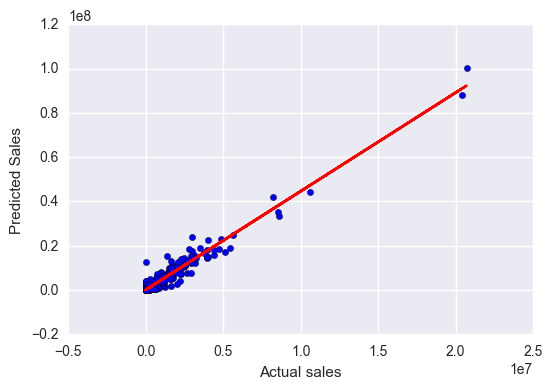

In [219]:
# Use the data from 2015 to make a linear model using as many variables 
# as you find useful to predict the yearly sales of each store. 
# You must use the sales from Jan to March per store as one of your variables.


# do not force it to go through zero
lm = linear_model.LinearRegression(fit_intercept = True)  

x = sales_store_jan_mar_2015
y = sales_store_2015

model = lm.fit(x, y)

print("Coefficients", model.coef_)
print("Intercept:", model.intercept_)
y_pred = model.predict(x)

# Use MAE when how far off an error is makes little difference.
# Use MSE when more extreme errors should have a large impact.
print("MSE:", mean_squared_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", mean_absolute_error(y, y_pred))
print("r^2:", metrics.r2_score(y, y_pred))


plt.scatter(x, y)
plt.xlabel("Actual sales")
plt.ylabel("Predicted Sales")
plt.plot(x, y_pred, color='red')


Coefficients [[ 0.96966354]]
Intercept: [ 30884.36822103]
MSE: 148379672388.0
RMSE: 385200.820856
MAE: 168979.365911
r^2: 0.88621134666


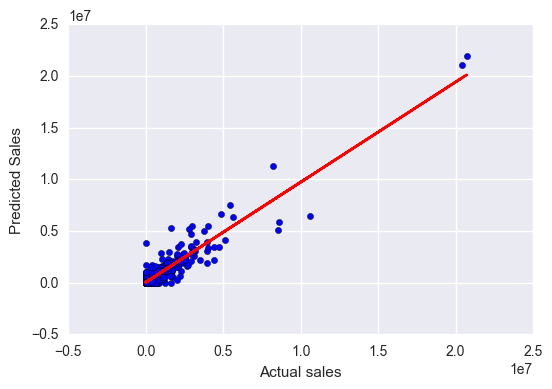

In [220]:

# do not force it to go through zero
lm = linear_model.LinearRegression(fit_intercept = True)  

x = sales_store_jan_mar_2015
y = sales_store_2016

model = lm.fit(x, y)

print("Coefficients", model.coef_)
print("Intercept:", model.intercept_)
y_pred = model.predict(x)

# Use MAE when how far off an error is makes little difference.
# Use MSE when more extreme errors should have a large impact.
print("MSE:", mean_squared_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", mean_absolute_error(y, y_pred))
print("r^2:", metrics.r2_score(y, y_pred))


plt.scatter(x, y)
plt.xlabel("Actual sales")
plt.ylabel("Predicted Sales")
plt.plot(x, y_pred, color='red')



## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.